<a href="https://colab.research.google.com/github/Souradeep10/BookMyshowAssignment/blob/master/analytics_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=8bf77a119b69eab1a4d2d8798895c4beaee01fd32d9572845fe9d1802e773068
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
#@title Default title text
## Download Input dataset for analytics
# https://propensity-labs-screening.s3.amazonaws.com/analytics/analytics_input.csv

In [2]:
#Create Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder \
                    .master('local[1]') \
                    .appName('SparkInterview') \
                    .getOrCreate()


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
mount='/content/drive'
path = mount+'/My Drive/Colab Notebooks/analytics_input.csv'
df = spark.read.option("header",True).csv(path)

In [16]:
#Display Scheme
df.printSchema()

root
 |-- DRG Definition: string (nullable = true)
 |-- Provider Id: string (nullable = true)
 |-- Provider Name: string (nullable = true)
 |-- Provider Street Address: string (nullable = true)
 |-- Provider City: string (nullable = true)
 |-- Provider State: string (nullable = true)
 |-- Provider Zip Code: string (nullable = true)
 |-- Hospital Referral Region Description: string (nullable = true)
 |--  Total Discharges : string (nullable = true)
 |--  Average Covered Charges : string (nullable = true)
 |--  Average Total Payments : string (nullable = true)
 |-- Average Medicare Payments: string (nullable = true)



In [5]:
#Change Column names to remove spaces, lower case and replace spaces in column names with "_" (underscore)

for name in df.schema.names:
  df = df.withColumnRenamed(name, name.replace(' ', '_').lower())
print(df.columns)

['drg_definition', 'provider_id', 'provider_name', 'provider_street_address', 'provider_city', 'provider_state', 'provider_zip_code', 'hospital_referral_region_description', '_total_discharges_', '_average_covered_charges_', '_average_total_payments_', 'average_medicare_payments']


In [12]:
#Identify all rows with Null values for provider id
df.filter(df.provider_id.isNull()).show()

+--------------+-----------+-------------+-----------------------+-------------+--------------+-----------------+------------------------------------+------------------+-------------------------+------------------------+-------------------------+
|drg_definition|provider_id|provider_name|provider_street_address|provider_city|provider_state|provider_zip_code|hospital_referral_region_description|_total_discharges_|_average_covered_charges_|_average_total_payments_|average_medicare_payments|
+--------------+-----------+-------------+-----------------------+-------------+--------------+-----------------+------------------------------------+------------------+-------------------------+------------------------+-------------------------+
+--------------+-----------+-------------+-----------------------+-------------+--------------+-----------------+------------------------------------+------------------+-------------------------+------------------------+-------------------------+



In [6]:
#Change fields with Payment information into numbers by using Lambda functions in python
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

convert_payment_udf = udf(lambda payment: float(payment.replace("$", "")), FloatType())
columns_to_update = ["_average_covered_charges_", "_average_total_payments_","average_medicare_payments"]
for column in columns_to_update:
    df = df.withColumn(column, convert_payment_udf(df[column]))

df.show()


+--------------------+-----------+--------------------+-----------------------+-------------+--------------+-----------------+------------------------------------+------------------+-------------------------+------------------------+-------------------------+
|      drg_definition|provider_id|       provider_name|provider_street_address|provider_city|provider_state|provider_zip_code|hospital_referral_region_description|_total_discharges_|_average_covered_charges_|_average_total_payments_|average_medicare_payments|
+--------------------+-----------+--------------------+-----------------------+-------------+--------------+-----------------+------------------------------------+------------------+-------------------------+------------------------+-------------------------+
|039 - EXTRACRANIA...|      10001|SOUTHEAST ALABAMA...|   1108 ROSS CLARK C...|       DOTHAN|            AL|            36301|                         AL - Dothan|                91|                 32963.07|            

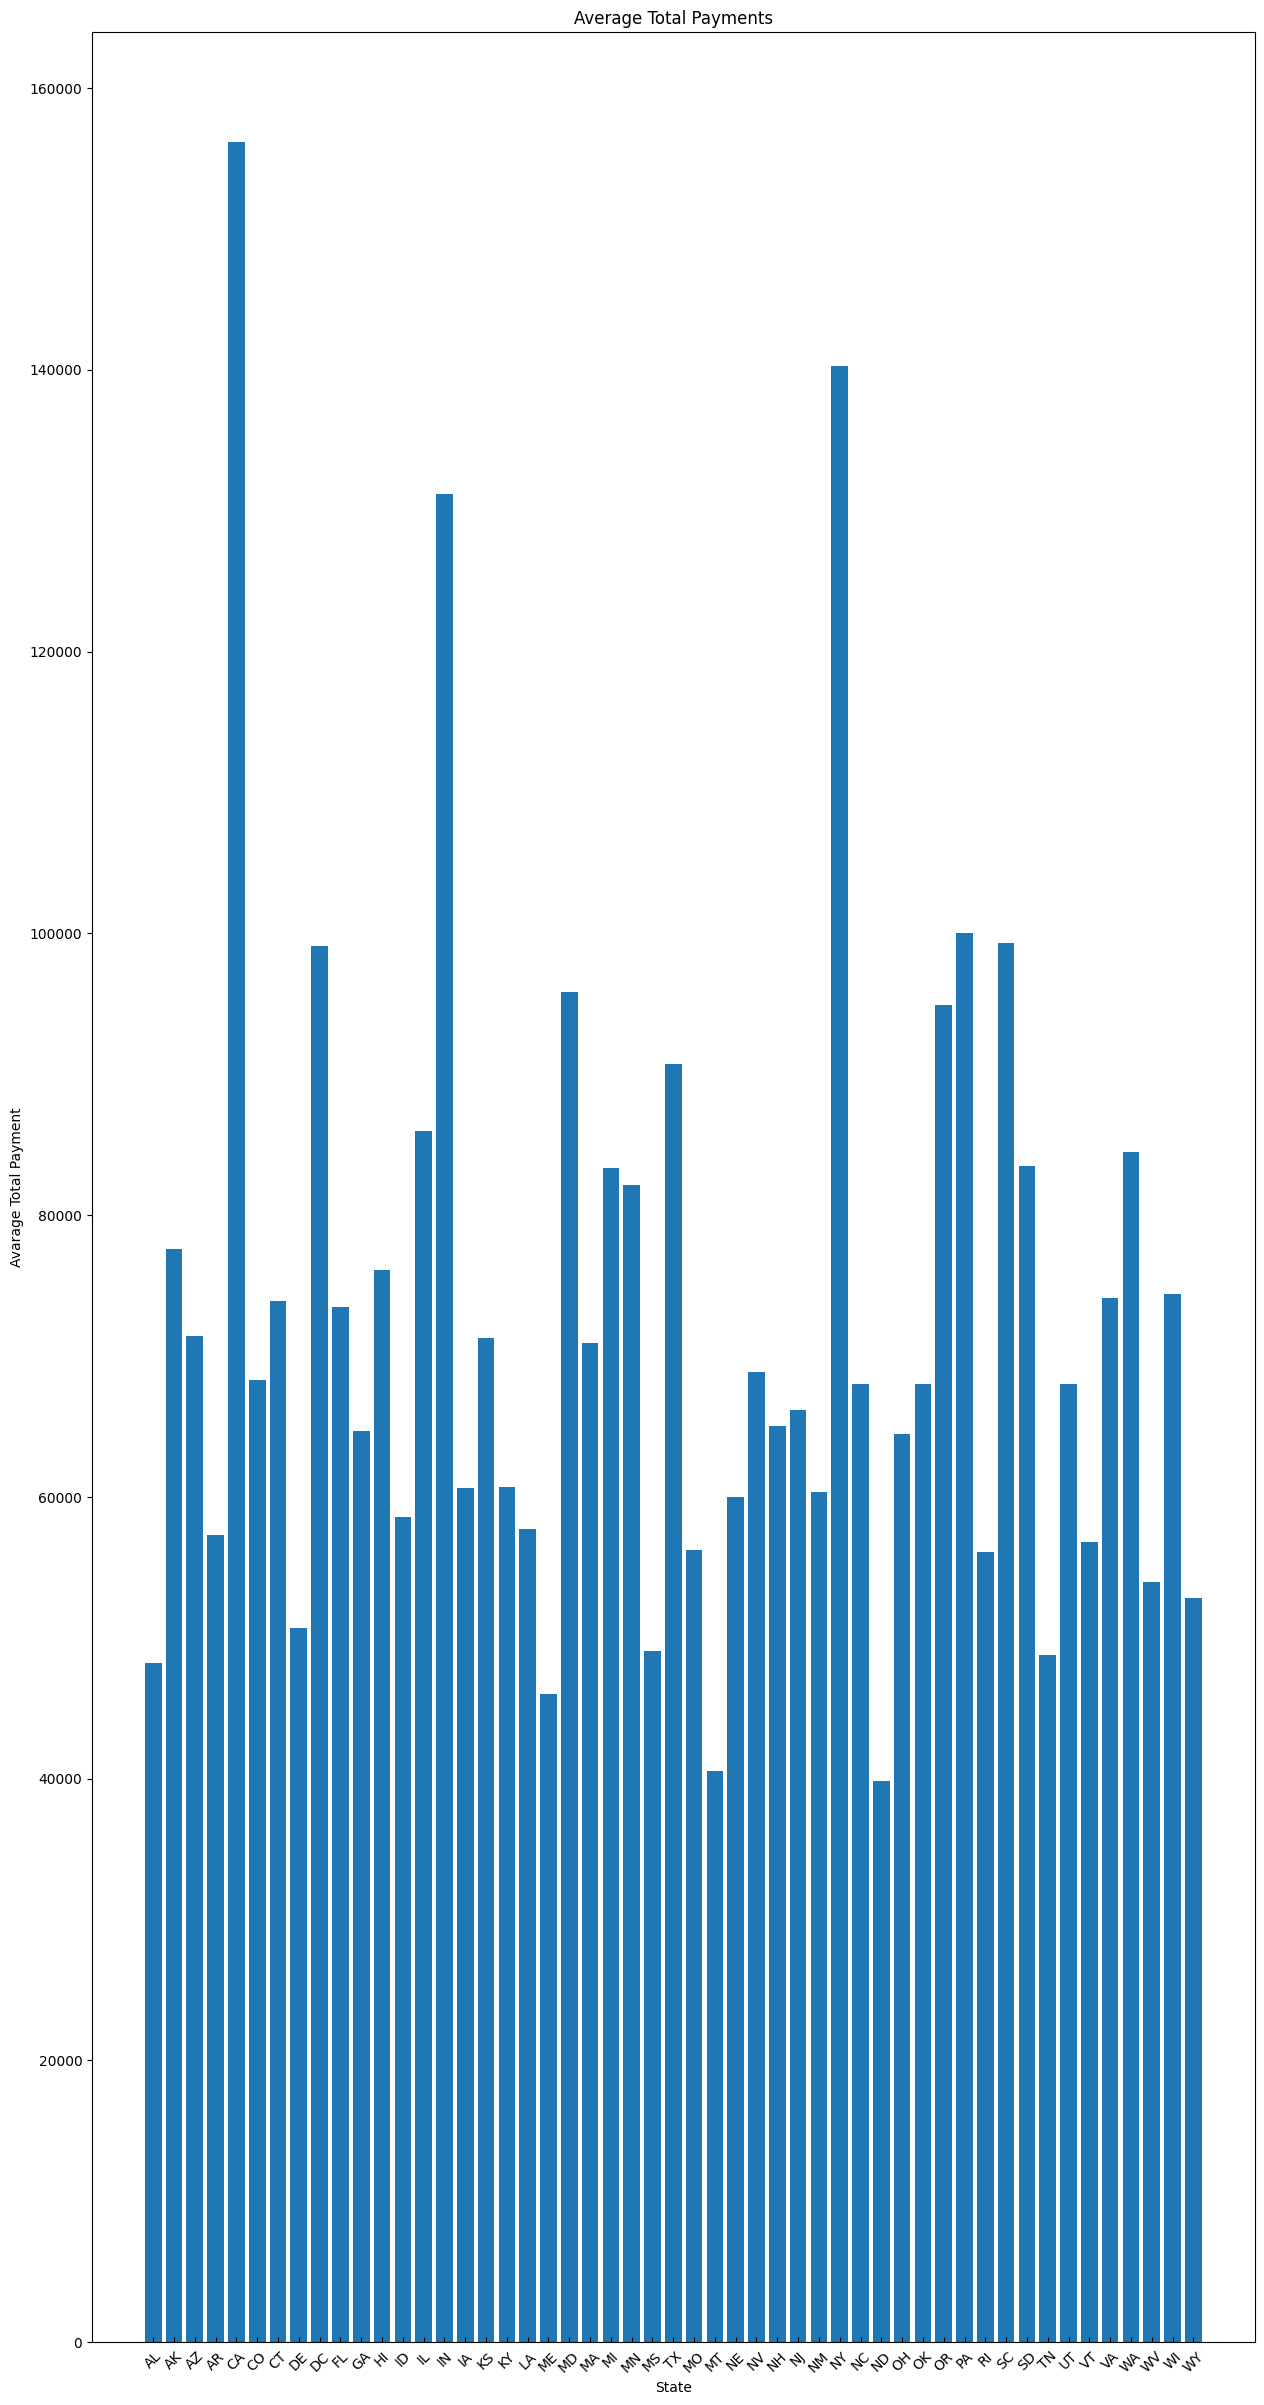

In [14]:
#Plot a Bar chart by state and "Average Total Payments" and zip code vs "total_charges"
import matplotlib.pyplot as plt
pandas_df = df.select("provider_state", "_average_total_payments_").toPandas()
pandas_df["_average_total_payments_"] = pandas_df["_average_total_payments_"].astype(float)
plt.bar( pandas_df["provider_state"],pandas_df["_average_total_payments_"])
plt.title("Average Total Payments")
plt.xlabel("State")
plt.ylabel("Avarage Total Payment")
plt.tick_params(axis="x", direction="in", pad=5)
plt.rcParams['figure.figsize'] = (15, 30)
plt.xticks(rotation=45)
plt.show()



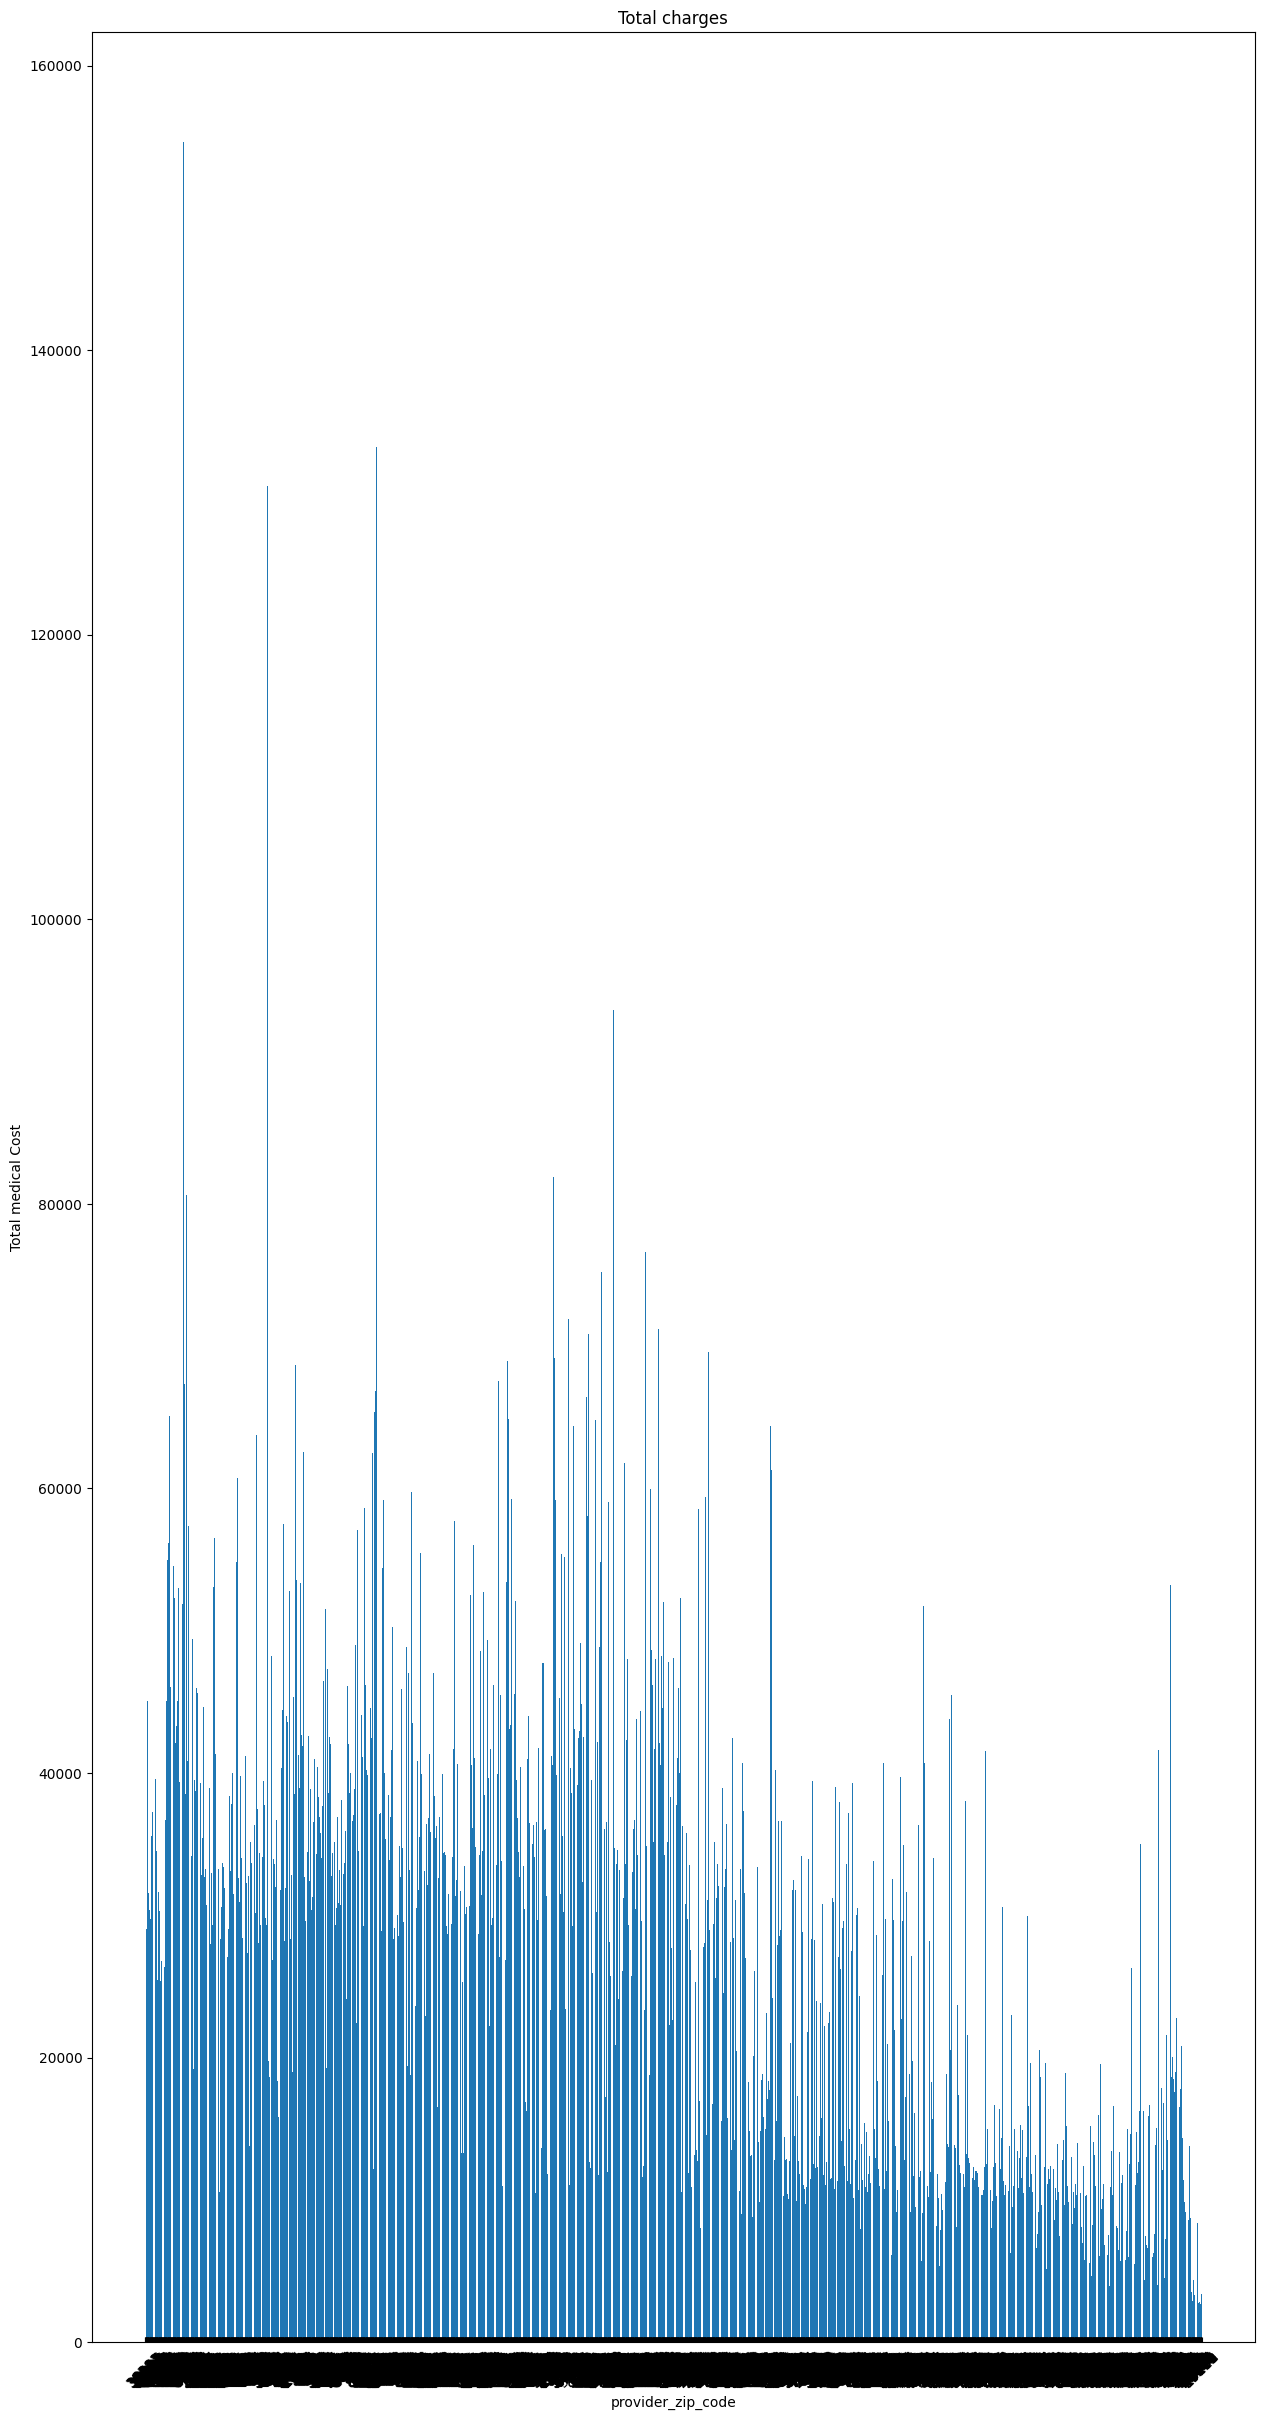

In [13]:
import matplotlib.pyplot as plt

pandas_df["average_medicare_payments"] = pandas_df["average_medicare_payments"].astype(float)

plt.bar( pandas_df["provider_zip_code"],pandas_df["average_medicare_payments"])
plt.title("Total charges")
plt.xlabel("provider_zip_code")
plt.ylabel("Total medical Cost")
plt.tick_params(axis="x", direction="in", pad=5)
plt.rcParams['figure.figsize'] = (15, 30)
plt.xticks(rotation=45)
plt.show()

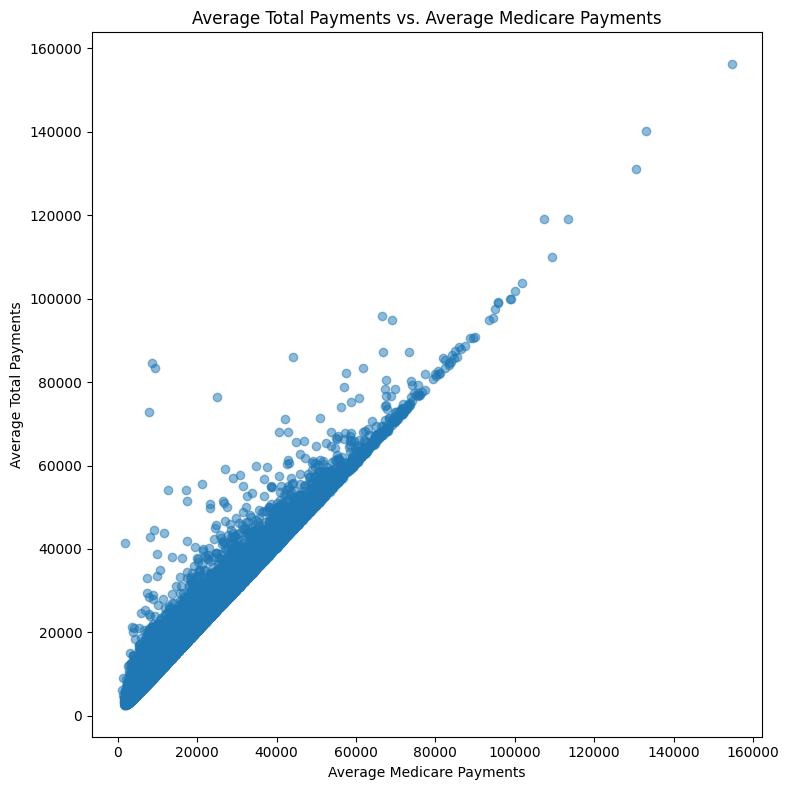

In [23]:
#BONUS - Plot intersting statistics from the dataset
import matplotlib.pyplot as plt


pandas_df = df.select("_average_total_payments_","average_medicare_payments").toPandas()

plt.figure(figsize=(8, 8))
plt.scatter(pandas_df['average_medicare_payments'], pandas_df['_average_total_payments_'], alpha=0.5)
plt.xlabel('Average Medicare Payments')
plt.ylabel('Average Total Payments')
plt.title('Average Total Payments vs. Average Medicare Payments')
plt.tight_layout()
plt.show()


In [16]:
#Write the Dataset to a Parquet format partitioned by State
mount='/content/drive'
path = mount+'/My Drive/Colab Notebooks/output'
df.write.partitionBy('provider_state').parquet(path)
